### Visualizing the classification manifold of NONA VS LR VS KNN on differently arranged synthetic data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LogisticRegression
from models import NONA
from mpl_toolkits import mplot3d
from sklearn.neighbors import KNeighborsClassifier

Linearly separable data

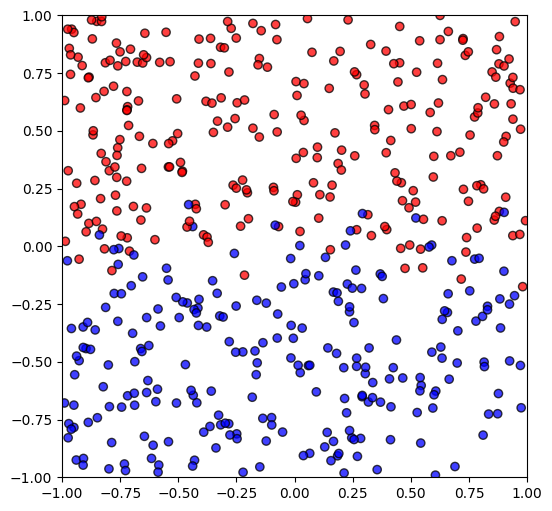

Class distribution: (array([0., 1.]), array([236, 264]))


In [2]:
np.random.seed(42)

num_samples = 500
X = np.random.uniform(-1,1, (num_samples,2))

m = 0 
b = 0.0 

noise = np.random.normal(0, 0.1, num_samples)
y = (X[:, 1] > (m * X[:, 0] + b + noise)).astype(int)

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.75)
x_vals = np.linspace(-1, 1, 100)
# plt.plot(x_vals, m * x_vals + b, 'k--', label="Decision boundary")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

print('Class distribution:', np.unique(y, return_counts=True))

Alt: clustered linearly separable data

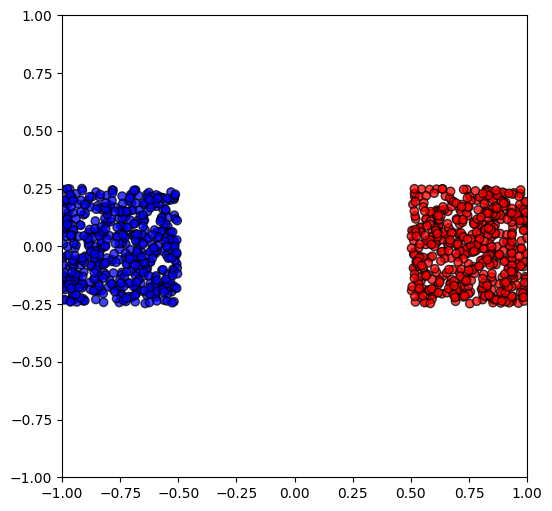

In [3]:
np.random.seed(42)

num_samples = 500
X_00 = np.random.uniform(-1,-0.5, size=(num_samples,))
X_01 = np.random.uniform(-0.25, 0.25, size=(num_samples,))
X_10 = np.random.uniform(0.5, 1, size=(num_samples,))
X_11 = np.random.uniform(-0.25, 0.25, size=(num_samples,))

X_0 = np.stack([X_00, X_01]).T
X_1 = np.stack([X_10, X_11]).T


X = np.concatenate([X_0, X_1])


y_0 = np.zeros(num_samples)
y_1 = np.ones(num_samples)

y = np.concatenate([y_0,y_1])

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.75)
x_vals = np.linspace(0, 1, 100)
# plt.plot(x_vals, m * x_vals + b, 'k--', label="Decision boundary")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

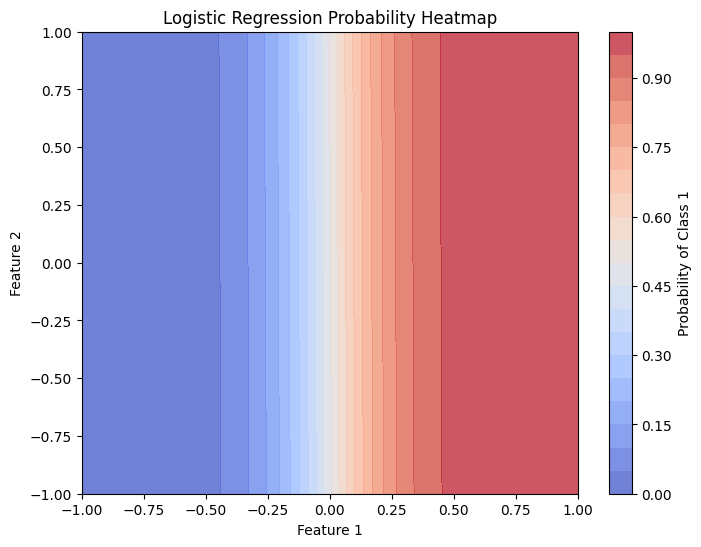

In [4]:
model = LogisticRegression()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
axes = 1
xx, yy = np.meshgrid(np.linspace(-axes, axes, grid_size), np.linspace(-axes, axes, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

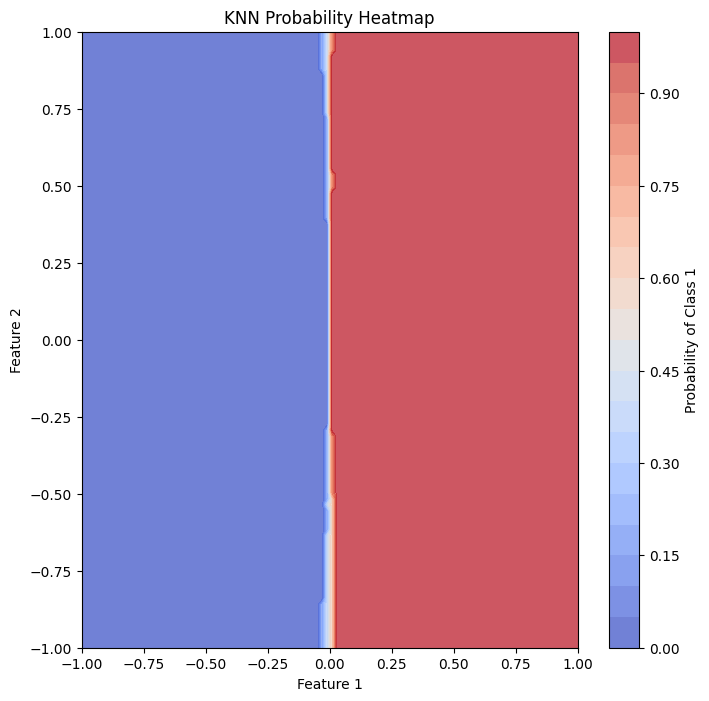

In [5]:
model = KNeighborsClassifier()
model.fit(X,y)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

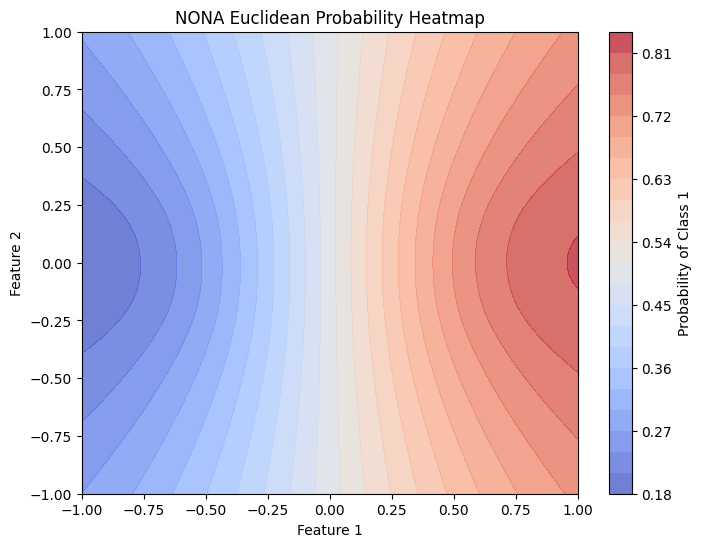

In [6]:
model = NONA()
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

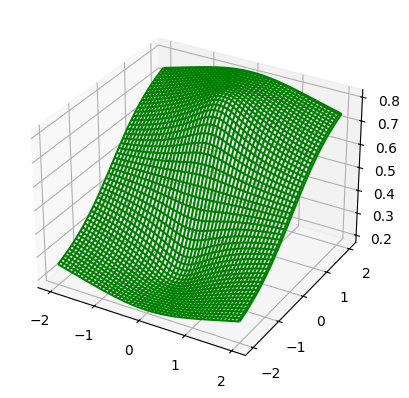

In [7]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

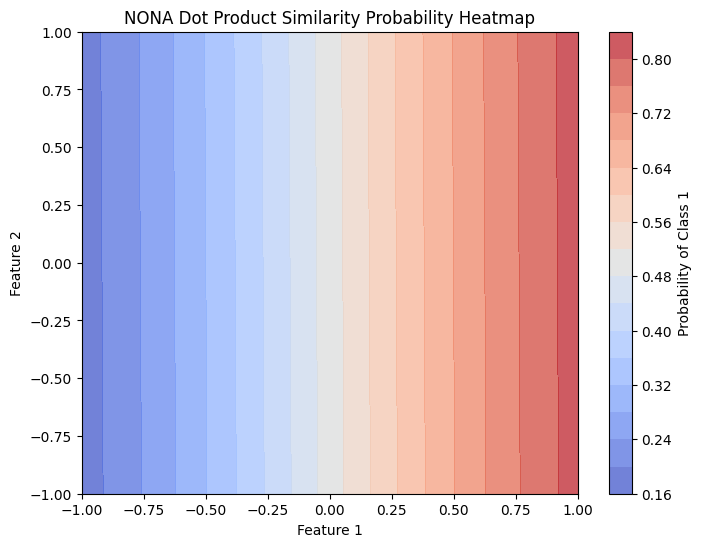

In [8]:
model = NONA(similarity='dot')
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

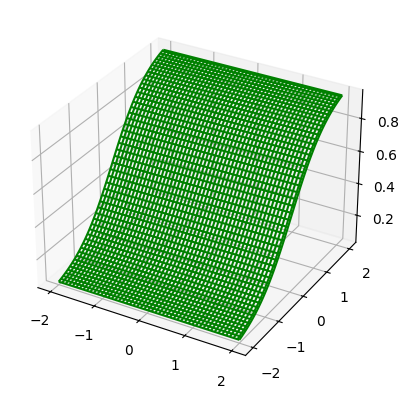

In [9]:
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

grid = torch.cartesian_prod(x_grid, y_grid)

Z = model(grid, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

Radially separable data

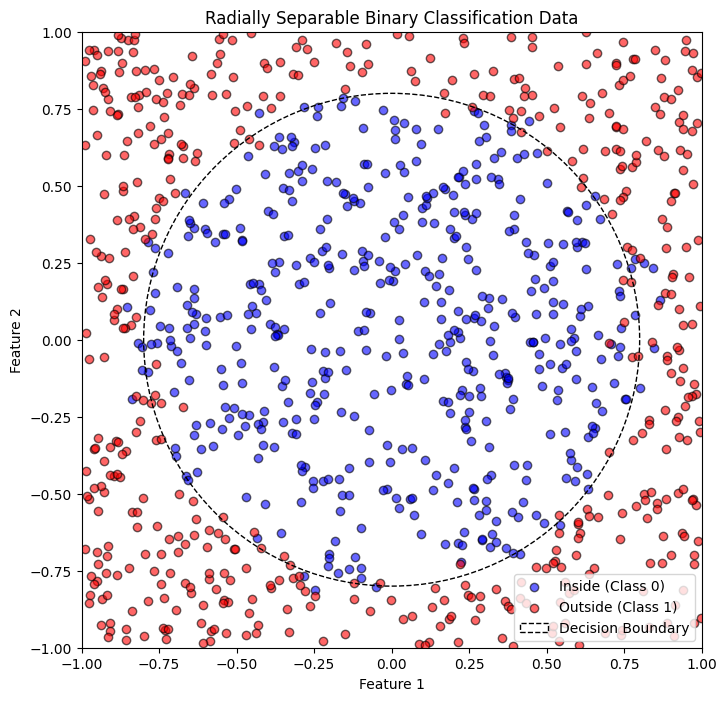

Class distribution (array([0., 1.]), array([493, 507]))


In [10]:
np.random.seed(42)

n_samples = 1000
X = np.random.uniform(-1,1, size=(n_samples, 2))

# Define radial boundary
center = np.array([0, 0])
radius = 0.8 

distances = np.linalg.norm(X - center, axis=1)

# Assign labels based on radial distance, adding noise
y = (distances + 0.05 * np.random.randn(n_samples) > radius).astype(int)

X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)


# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Inside (Class 0)", alpha=0.6, edgecolor='k')
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Outside (Class 1)", alpha=0.6, edgecolor='k')

# Plot the true decision boundary
circle = plt.Circle(center, radius, color="black", linestyle="dashed", fill=False, label="Decision Boundary")
plt.gca().add_patch(circle)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Radially Separable Binary Classification Data")
plt.legend()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

print("Class distribution", np.unique(y, return_counts=True))

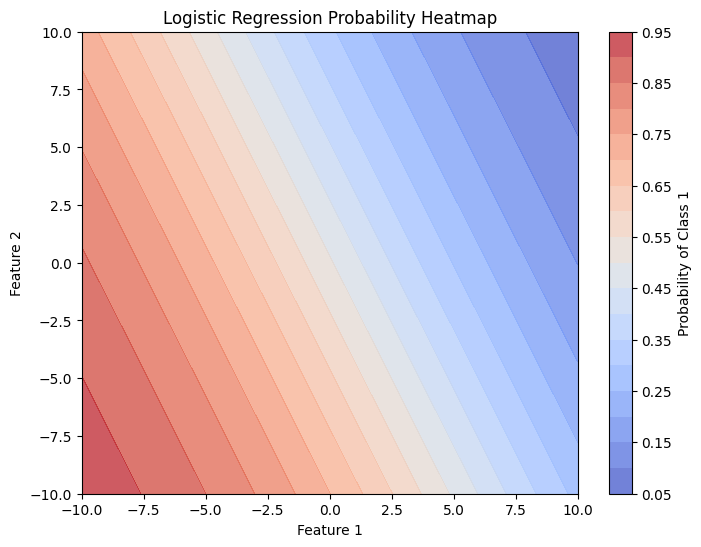

In [11]:
model = LogisticRegression()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
xx, yy = np.meshgrid(np.linspace(-10, 10, grid_size), np.linspace(-10, 10, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

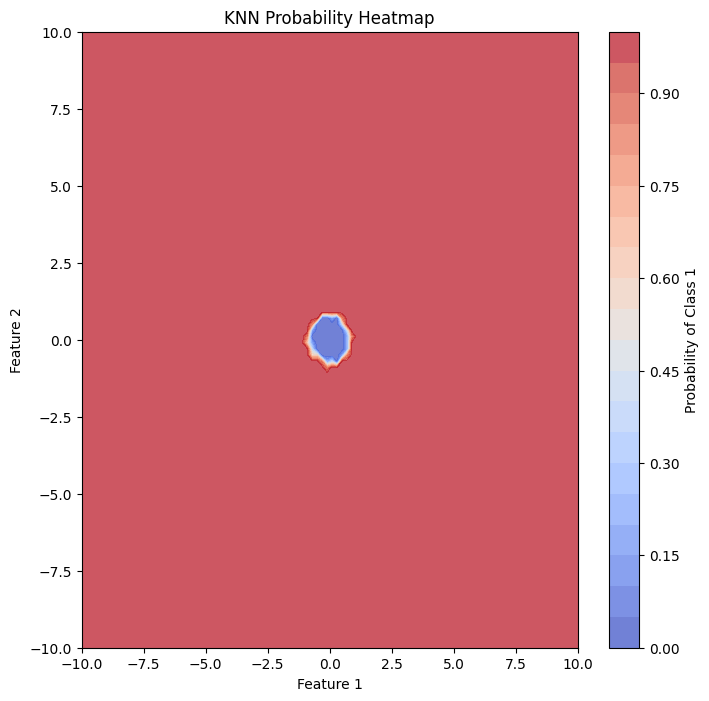

In [12]:
model = KNeighborsClassifier()
model.fit(X,y)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

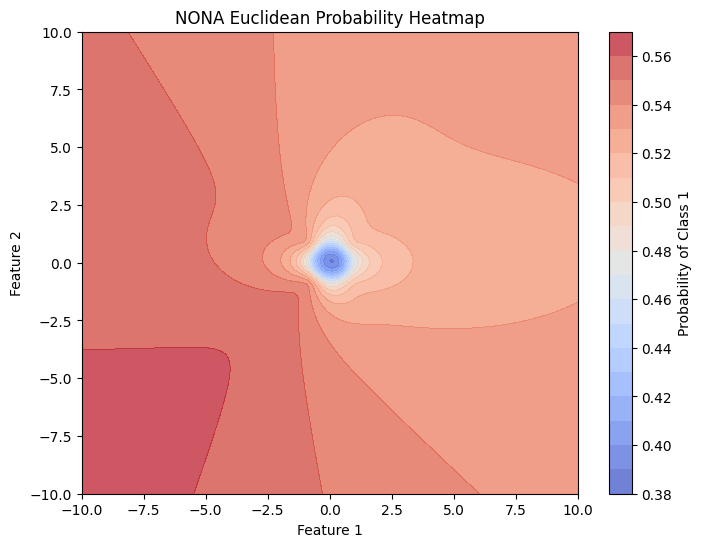

In [13]:
model = NONA()
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

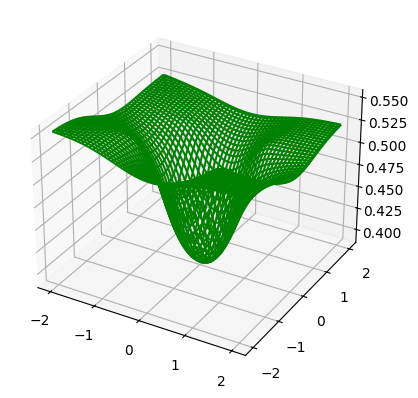

In [14]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

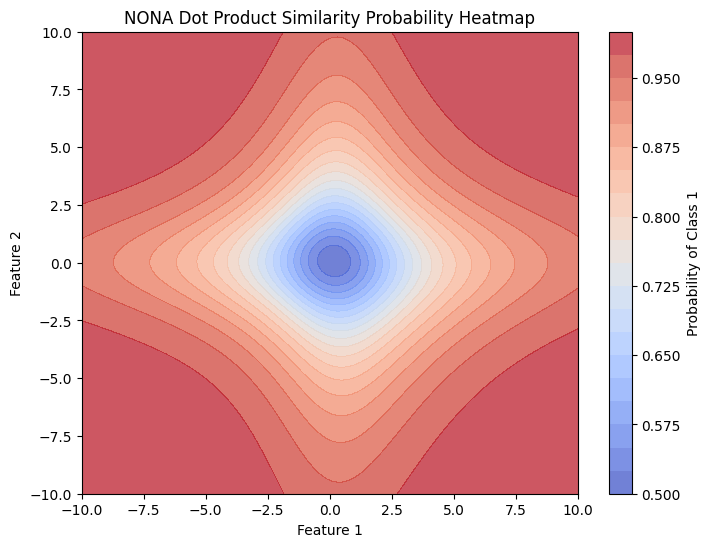

In [15]:
model = NONA(similarity='dot')
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size).cpu().detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

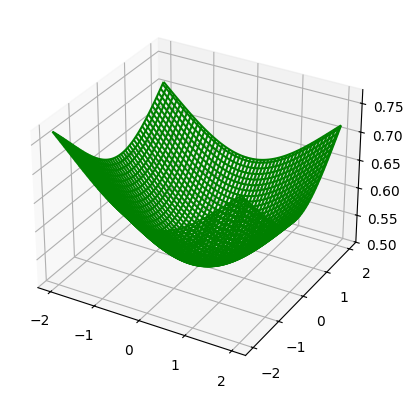

In [16]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()

X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

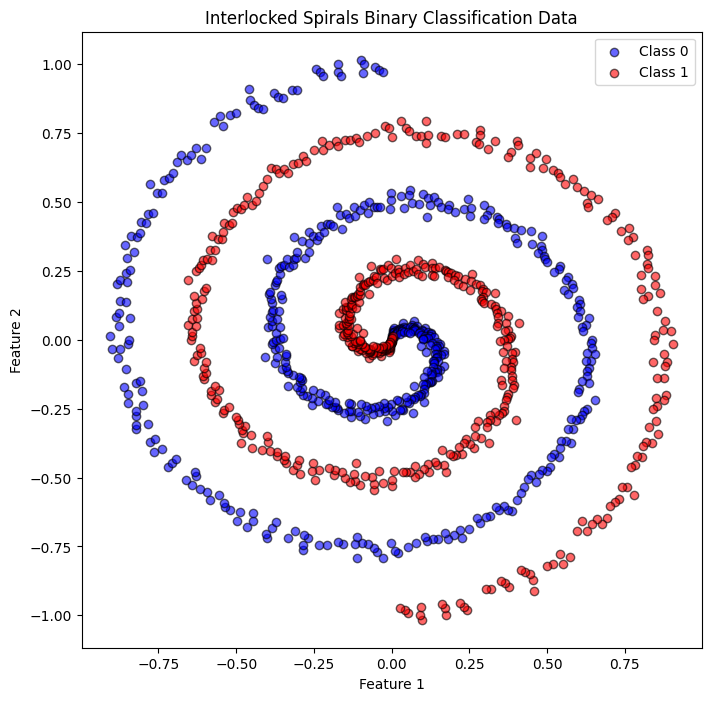

In [17]:
np.random.seed(42)

# Generate data for two interlocked spirals
n_samples = 500
theta = np.linspace(0, 4 * np.pi, n_samples)
r = np.linspace(0, 1, n_samples)
noise = np.random.normal(0, 0.02, num_samples)

phase_0 = 0
X_0 = np.array([(r + noise) * np.sin(theta + phase_0 + noise), (r + noise) * np.cos(theta + phase_0 + noise)]).T
y_0 = np.zeros(n_samples)

phase_1 = np.pi
X_1 = np.array([(r + noise) * np.sin(theta + phase_1 + noise), (r + noise) * np.cos(theta + phase_1 + noise)]).T
y_1 = np.ones(n_samples)

X = np.concat([X_0, X_1], axis=0)
y = np.concat([y_0, y_1], axis=0)


X = torch.tensor(X, dtype=torch.float64)
y = torch.tensor(y, dtype=torch.float64)

# Plot the data
plt.figure(figsize=(8, 8))
plt.scatter(X_0[:,0], X_0[:,1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
plt.scatter(X_1[:,0], X_1[:,1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Interlocked Spirals Binary Classification Data")
plt.legend()
plt.show()


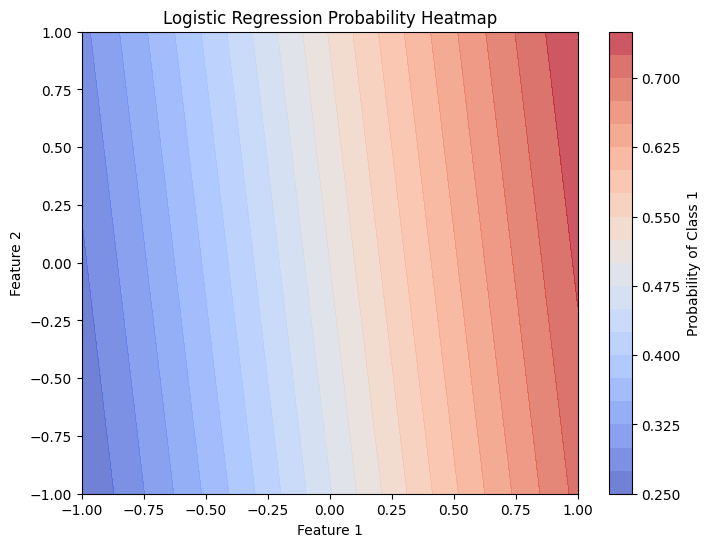

In [18]:
model = LogisticRegression()
model.fit(X, y)

# Create a grid over [0,1]^2 for visualization
grid_size = 100
xx, yy = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float64)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Logistic Regression Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

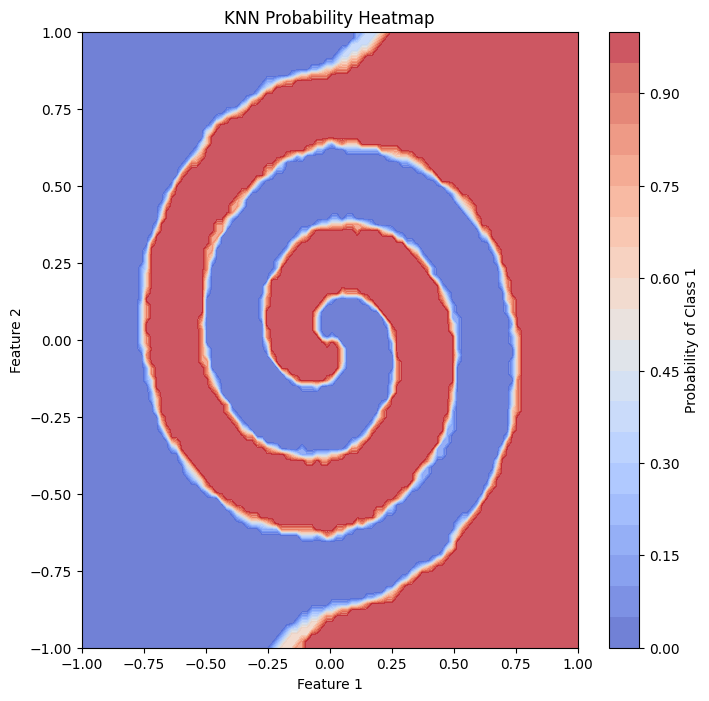

In [19]:
model = KNeighborsClassifier()
model.fit(X,y)
probabilities = model.predict_proba(grid_points)[:, 1].reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

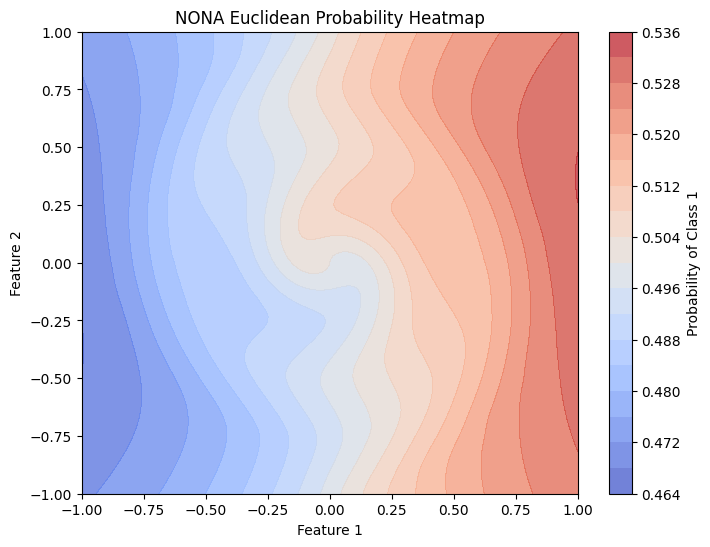

In [20]:
model = NONA()
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size)

# Plot the heatmap using contourf
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Euclidean Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

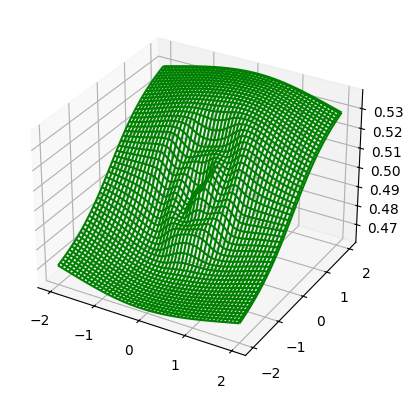

In [21]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()
x_grid = x_grid.detach()
y_grid = y_grid.detach()
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')

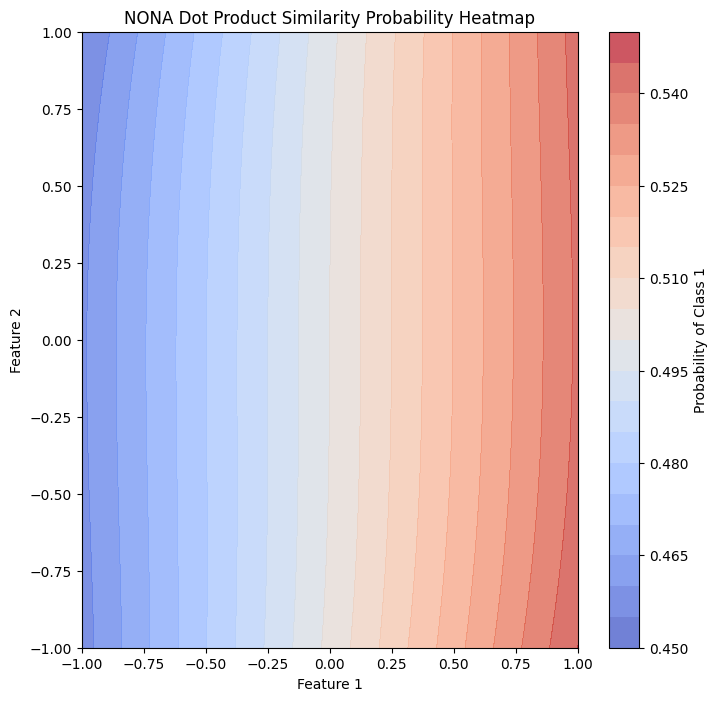

In [22]:
model = NONA(similarity='dot')
probabilities = model(grid_points, X, y).reshape(grid_size, grid_size).cpu().detach()

# Plot the heatmap using contourf
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, probabilities, levels=20, cmap="coolwarm", alpha=0.75)

# Scatter plot of data points
# plt.scatter(X[y == 0, 0], X[y == 0, 1], color="blue", label="Class 0", alpha=0.6, edgecolor='k')
# plt.scatter(X[y == 1, 0], X[y == 1, 1], color="red", label="Class 1", alpha=0.6, edgecolor='k')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("NONA Dot Product Similarity Probability Heatmap")
plt.colorbar(label="Probability of Class 1")
plt.show()

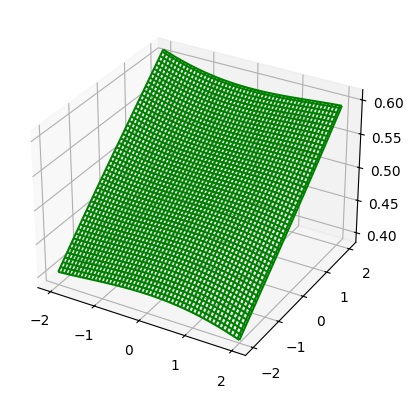

In [23]:
# x and y axis
x_grid = torch.linspace(-2, 2, 100).to(torch.float64)
y_grid = torch.linspace(-2, 2, 100).to(torch.float64)

X_test = torch.cartesian_prod(x_grid, y_grid)

Z = model(X_test, X, y).reshape(100,100).detach()
x_grid = x_grid.detach()
y_grid = y_grid.detach()
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.plot_wireframe(X_grid, Y_grid, Z, color ='green')